In [1]:
import matplotlib.pyplot as plt

In [2]:
import json
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
import geopandas as gpd

In [3]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [4]:
seoul = gpd.GeoDataFrame.from_file('./data/seoul', encoding='cp949')
seoul_songpa = seoul.query('COL_ADM_SE == "11710"')
seoul_songpa.reset_index(drop=True, inplace=True)

# cctv

In [8]:
cctv = pd.read_csv('./data/cctv_송파.csv')

In [9]:
cctv['lo']= cctv['geometry'].str.split(' ').str[1].str.replace('(','')
cctv['lo'] = cctv['lo'].astype('float')

cctv['la']= cctv['geometry'].str.split(' ').str[2].str.replace(')','')
cctv['la'] = cctv['la'].astype('float')

In [10]:
cctv.iloc[:,[4,5]]

,lo,la
0,968319.564853,1.942367e+06
1,965227.290417,1.947393e+06
2,966991.600669,1.942474e+06
3,967699.987101,1.942503e+06
4,967410.734003,1.942535e+06
...,...,...
1157,969306.069519,1.944516e+06
1158,966371.470207,1.945424e+06
1159,964782.516836,1.945040e+06
1160,966210.993465,1.948534e+06


In [11]:
from sklearn.cluster import KMeans

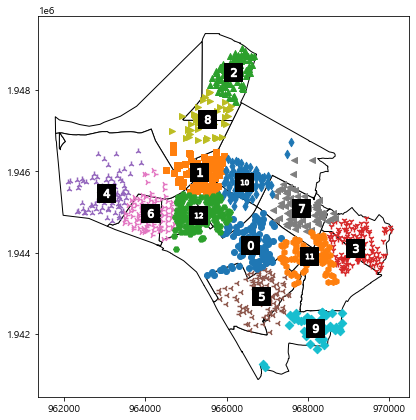

In [12]:
ax = seoul_songpa.plot(color='white',edgecolor='black',figsize=(7,7))


cctv_cluster = cctv.iloc[:,[4,5]]
kmeans = KMeans(n_clusters=13, init ='k-means++', max_iter = 300, random_state=0)
kmeans.fit(cctv_cluster)

cctv_cluster['target'] = kmeans.fit_predict(cctv_cluster)
centers = kmeans.cluster_centers_

marks = ['o','s','^','1','2','3','4','<','>','D','d','h','H']
for i in np.unique(cctv_cluster.target):
    target = cctv_cluster[cctv_cluster.target == i]        
    plt.scatter(x=target['lo'], y=target['la'], marker=marks[i])
    
    center_xy = centers[i]
    plt.scatter(x=center_xy[0],y=center_xy[1],s=300,color='k',marker ='s')
    plt.scatter(x=center_xy[0],y=center_xy[1],s=70,color='white',marker ='$%d$'%i)

In [13]:
from sklearn.metrics import silhouette_samples, silhouette_score

cctv_cluster['silhouette_coeff'] = silhouette_samples(cctv_cluster.iloc[:,[0,1]],cctv_cluster['target'])
score = silhouette_score(cctv_cluster.iloc[:,[0,1]],cctv_cluster['target'])

print(score)

0.41889019737964184


In [14]:
cctv_cluser_result = pd.DataFrame (index=range(len(centers)), columns = {'target','주소','실루엣계수'})
cctv_cluser_result['target'] = cctv_cluser_result.index
cctv_cluser_result['실루엣계수'] = cctv_cluster.groupby('target')[['silhouette_coeff']].mean()

In [15]:
import requests

for i in range(len(centers)):
    url= "http://api.vworld.kr/req/address?"
    key = 'F2FA331D-A1EB-337A-ACF7-A42DBF7AA247'
    point1 = str(centers[i][0])
    point2 = str(centers[i][1])
    point = point1+','+point2
    
    params ={'service' : 'address', 
            'request' : 'getAddress','version' : '2.0',
            'refine' : 'true', 'simple' : 'false', 'type' : 'both',
            'crs' : 'epsg:5179', 'format' : 'json',
            'point': point,
            'key' : key}
    res = requests.get(url, params = params)
    json_data = res.json()
    
    cctv_cluser_result['주소'][i] = json_data['response']['result'][0]['text']
    
    
cctv_cluser_result

,실루엣계수,target,주소
0,0.336396,0,서울특별시 송파구 가락동 73-4
1,0.374253,1,서울특별시 송파구 신천동 32
2,0.597779,2,서울특별시 송파구 풍납동 222-18
3,0.470092,3,서울특별시 송파구 마천동 183-46
4,0.442659,4,서울특별시 송파구 잠실동 219-3
5,0.406187,5,서울특별시 송파구 문정동 66
6,0.379651,6,서울특별시 송파구 삼전동 144
7,0.390107,7,서울특별시 송파구 오금동 74-2
8,0.372187,8,서울특별시 송파구 풍납동 471
9,0.580031,9,서울특별시 송파구 장지동 899


In [189]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import estimate_bandwidth
cctv_cluster = cctv.iloc[:,[4,5]]

cctv_cluster['lo_log'] = np.log1p(cctv_cluster['lo'])
cctv_cluster['la_log'] = np.log1p(cctv_cluster['la'])
cctv_cluster

,lo,la,lo_log,la_log
0,968319.564853,1.942367e+06,13.783318,14.479418
1,965227.290417,1.947393e+06,13.780120,14.482002
2,966991.600669,1.942474e+06,13.781946,14.479474
3,967699.987101,1.942503e+06,13.782678,14.479488
4,967410.734003,1.942535e+06,13.782379,14.479505
...,...,...,...,...
1157,969306.069519,1.944516e+06,13.784337,14.480524
1158,966371.470207,1.945424e+06,13.781305,14.480991
1159,964782.516836,1.945040e+06,13.779659,14.480794
1160,966210.993465,1.948534e+06,13.781139,14.482588


In [251]:
dbscan = DBSCAN(eps=.6, min_samples=100, metric='euclidean')
cctv_cluster_log = cctv_cluster.iloc[:,[2,3]]
dbscan.fit(cctv_cluster_log)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cctv_cluster_scaled = scaler.fit_transform(cctv_cluster_log)


cctv_cluster['target'] = dbscan.fit_predict(cctv_cluster_scaled)
cctv_cluster

,lo,la,lo_log,la_log,target
0,968319.564853,1.942367e+06,13.783318,14.479418,-1
1,965227.290417,1.947393e+06,13.780120,14.482002,1
2,966991.600669,1.942474e+06,13.781946,14.479474,0
3,967699.987101,1.942503e+06,13.782678,14.479488,0
4,967410.734003,1.942535e+06,13.782379,14.479505,0
...,...,...,...,...,...
1157,969306.069519,1.944516e+06,13.784337,14.480524,0
1158,966371.470207,1.945424e+06,13.781305,14.480991,0
1159,964782.516836,1.945040e+06,13.779659,14.480794,0
1160,966210.993465,1.948534e+06,13.781139,14.482588,1


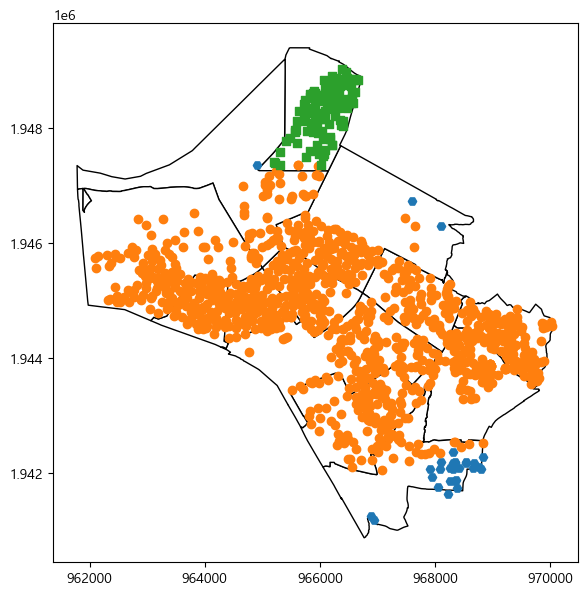

In [252]:
ax = seoul_songpa.plot(color='white',edgecolor='black',figsize=(7,7))

marks = ['o','s','^','1','2','3','4','<','>','D','d','h','H']
for i in np.unique(cctv_cluster.target):
    target = cctv_cluster[cctv_cluster.target == i]        
    plt.scatter(x=target['lo'], y=target['la'], marker=marks[i])
    
   # center_xy = centers[i]
   # plt.scatter(x=center_xy[0],y=center_xy[1],s=300,color='k',marker ='s')
   # plt.scatter(x=center_xy[0],y=center_xy[1],s=70,color='white',marker ='$%d$'%i)